# Early Stopping

Early stopping is an approach to training complex machine learning models to avoid overfitting. It works by monitoring the performance of the model that is being trained on a separate test dataset and stopping the training procedure once the performance on the test dataset has not improved after a fixed number of training iterations.

It avoids overfitting by attempting to automatically select the inflection point where perfor- mance on the test dataset starts to decrease while performance on the training dataset continues to improve as the model starts to overfit. The performance measure may be the loss function that is being optimized to train the model (such as logarithmic loss), or an external metric of interest to the problem in general (such as classification accuracy).


# Monitoring Training Performance
The XGBoost model can evaluate and report on the performance on a test set for the model during training. It supports this capability by specifying both an test dataset and an evaluation metric on the call to model.fit() when training the model and specifying verbose output. For example, we can report on the binary classification error rate (error) on a standalone test set(eval set) while training an XGBoost model.

In [3]:
#Load Libraries
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Load Data and split
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'
data = read_csv(url, header=None, delimiter = ",")
X = data.values[:,0:8]
Y = data.values[:,8]

#Split Train/Test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 7)

#Fit Model
model = XGBClassifier()
eval_set = [(X_test, Y_test)]
model.fit(X_train, Y_train, eval_metric = "error", eval_set=eval_set, verbose=True)
#Predict
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
#Evaluate
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
             

[0]	validation_0-error:0.259843
[1]	validation_0-error:0.26378
[2]	validation_0-error:0.26378
[3]	validation_0-error:0.255906
[4]	validation_0-error:0.255906
[5]	validation_0-error:0.26378
[6]	validation_0-error:0.23622
[7]	validation_0-error:0.255906
[8]	validation_0-error:0.248031
[9]	validation_0-error:0.248031
[10]	validation_0-error:0.248031
[11]	validation_0-error:0.232283
[12]	validation_0-error:0.228346
[13]	validation_0-error:0.228346
[14]	validation_0-error:0.228346
[15]	validation_0-error:0.228346
[16]	validation_0-error:0.228346
[17]	validation_0-error:0.228346
[18]	validation_0-error:0.224409
[19]	validation_0-error:0.232283
[20]	validation_0-error:0.232283
[21]	validation_0-error:0.23622
[22]	validation_0-error:0.23622
[23]	validation_0-error:0.232283
[24]	validation_0-error:0.228346
[25]	validation_0-error:0.228346
[26]	validation_0-error:0.224409
[27]	validation_0-error:0.224409
[28]	validation_0-error:0.228346
[29]	validation_0-error:0.232283
[30]	validation_0-error:0.

Reviewing all of the output, we can see that the model performance on the test set sits flat and even gets worse towards the end of training.

# Evaluate XGBoost Models with Learning Curves
We can retrieve the performance of the model on the evaluation dataset and plot it to get insight into how learning unfolded while training. We provide an array of X and y pairs to the eval metric argument when fitting our XGBoost model. In addition to a test set, we can also provide the training dataset. This will provide a report on how well the model is performing on both training and test sets during training.

Accuracy: 77.95%


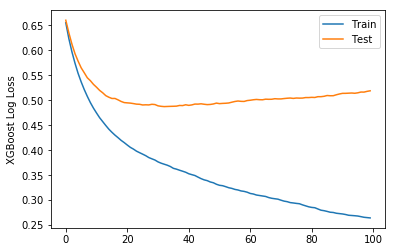

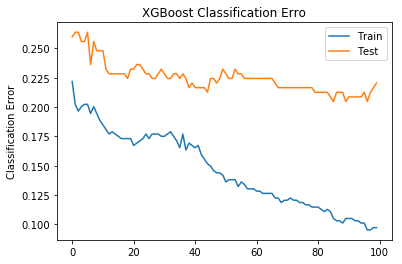

In [8]:
#Load Libraries
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

#Load Data and split
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'
data = read_csv(url, header=None, delimiter = ",")
X = data.values[:,0:8]
Y = data.values[:,8]

#Split Train/Test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 7)

#Fit Model
model = XGBClassifier()
eval_set = [(x_train, y_train),(x_test, y_test)]
model.fit(X_train, Y_train, eval_metric = ["error","logloss"], eval_set=eval_set, verbose=False)
#Predict
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
#Evaluate
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#Retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

#plot logloss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.ylabel('XGBoost Log Loss')
pyplot.show()

#plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label="Train")
ax.plot(x_axis, results['validation_1']['error'], label="Test")
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Erro')
pyplot.show()

From reviewing the logloss plot, it looks like there is an opportunity to stop the learning early, perhaps somewhere around epoch 20 to epoch 40. We see a similar story for classification error, where error appears to go back up at around epoch 40.


# Early Stopping with XGBoost

In [9]:
#Load Libraries
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

#Load Data and split
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'
data = read_csv(url, header=None, delimiter = ",")
X = data.values[:,0:8]
Y = data.values[:,8]

#Split Train/Test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 7)

#Fit Model
model = XGBClassifier()
eval_set = [(x_test, y_test)]
model.fit(X_train, Y_train, early_stopping_rounds = 10,
          eval_metric = "logloss", eval_set=eval_set, verbose=True)
#Predict
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
#Evaluate
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


[0]	validation_0-logloss:0.660186
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.634854
[2]	validation_0-logloss:0.612239
[3]	validation_0-logloss:0.593118
[4]	validation_0-logloss:0.578303
[5]	validation_0-logloss:0.564942
[6]	validation_0-logloss:0.555113
[7]	validation_0-logloss:0.54499
[8]	validation_0-logloss:0.539151
[9]	validation_0-logloss:0.531819
[10]	validation_0-logloss:0.526065
[11]	validation_0-logloss:0.51977
[12]	validation_0-logloss:0.514979
[13]	validation_0-logloss:0.50927
[14]	validation_0-logloss:0.506086
[15]	validation_0-logloss:0.503565
[16]	validation_0-logloss:0.503591
[17]	validation_0-logloss:0.500805
[18]	validation_0-logloss:0.497605
[19]	validation_0-logloss:0.495328
[20]	validation_0-logloss:0.494777
[21]	validation_0-logloss:0.494274
[22]	validation_0-logloss:0.493333
[23]	validation_0-logloss:0.492211
[24]	validation_0-logloss:0.491936
[25]	validation_0-logloss:0.490578
[26]	validation_0-logloss:0.490895
